# Cluster Panorama Explorer (Angles, Headings, FOVs)

This notebook explores the positioning of panorama points vs. control points, and visualizes view angles, headings, and FOVs for a chosen cluster (default: 22). It also displays the corresponding downloaded Street View images to compare with the geometric plots.

In [12]:
# 1) Imports
import os
from pathlib import Path
import math
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from shapely.ops import transform as shp_transform
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle
from PIL import Image
from IPython.display import display
from pyproj import Transformer

# Inline plots
%matplotlib inline

In [13]:
# 2) Config
DATA_DIR = Path('../data/tresdefebrero')  # adjust if using another dataset
CLUSTER_ID = 6934  # as requested
# Images saved by streetview_image_downloader.ipynb: ../data/tresdefebrero/image_testing/<cluster_id>/<view_id>.jpg
IMAGES_BASE_DIR = DATA_DIR / 'image_testing' / str(CLUSTER_ID)

# Files produced by the pipeline/components.py
HFOV_CSV = DATA_DIR / 'heading_fov.csv'
PANOS_CSV = DATA_DIR / 'panos.csv'
CENTROIDS_CSV = DATA_DIR / 'dbscan_centroids.csv'

print('Using:')
print('  heading_fov:', HFOV_CSV)
print('  panos      :', PANOS_CSV)
print('  centroids  :', CENTROIDS_CSV)
print('  images dir :', IMAGES_BASE_DIR)

Using:
  heading_fov: ../data/tresdefebrero/heading_fov.csv
  panos      : ../data/tresdefebrero/panos.csv
  centroids  : ../data/tresdefebrero/dbscan_centroids.csv
  images dir : ../data/tresdefebrero/image_testing/6934


In [14]:
# 3) Load Data
df_hfov = pd.read_csv(HFOV_CSV, index_col=0)
df_panos = pd.read_csv(PANOS_CSV)
df_centroids = pd.read_csv(CENTROIDS_CSV)

# Filter cluster
has_cluster = (df_hfov['cluster_id'] == CLUSTER_ID).any()
if not has_cluster:
    print(f'WARNING: cluster {CLUSTER_ID} not found in heading_fov.csv. Showing first available cluster instead.')
    CLUSTER_ID = int(df_hfov['cluster_id'].iloc[0])
    IMAGES_BASE_DIR = DATA_DIR / 'image_testing' / str(CLUSTER_ID)

hfov_c = df_hfov[df_hfov['cluster_id'] == CLUSTER_ID].copy()
related_panos = hfov_c.pano_id.unique().tolist()
panos_c = df_panos[df_panos['pano_id'].isin(related_panos)].copy()
centroid_row = df_centroids[df_centroids['cluster_id'] == CLUSTER_ID].head(1)

print(f'Cluster {CLUSTER_ID}: {len(hfov_c)} view records, {panos_c.shape[0]} panorama points')
hfov_c.head()

Cluster 6934: 16 view records, 4 panorama points


pano_id  cluster_id direction  heading   fov  \
85309  KY3gfZaGhHXTh5H225BY2g        6934         N    84.87  95.8   
85310  KY3gfZaGhHXTh5H225BY2g        6934         E   357.43  81.5   
85311  KY3gfZaGhHXTh5H225BY2g        6934         S   277.25  83.5   
85312  KY3gfZaGhHXTh5H225BY2g        6934         W   186.66  99.2   
85313  WKDQ5h_T-ZfcSXgo1gzvyw        6934         N    90.70  83.7   

                        view_id  
85309  KY3gfZaGhHXTh5H225BY2g_N  
85310  KY3gfZaGhHXTh5H225BY2g_E  
85311  KY3gfZaGhHXTh5H225BY2g_S  
85312  KY3gfZaGhHXTh5H225BY2g_W  
85313  WKDQ5h_T-ZfcSXgo1gzvyw_N

In [15]:
df_panos.shape

(31024, 4)

In [16]:
panos_c

pano_id        lat        lon  \
10271  KY3gfZaGhHXTh5H225BY2g -34.619758 -58.556572   
15969  WKDQ5h_T-ZfcSXgo1gzvyw -34.619770 -58.556563   
21929  hOsqqeoKweUhJ6lGAeKnRA -34.619754 -58.556576   
29226  wNkDQ1prZx4Elk6Uj7d9xg -34.619773 -58.556537   

                                            geometry  
10271   POINT (-58.55657152721652 -34.6197580908247)  
15969  POINT (-58.55656289587202 -34.61976985520495)  
21929  POINT (-58.55657562492576 -34.61975423924101)  
29226  POINT (-58.55653656591601 -34.61977290695892)

In [17]:
panos_c

pano_id        lat        lon  \
10271  KY3gfZaGhHXTh5H225BY2g -34.619758 -58.556572   
15969  WKDQ5h_T-ZfcSXgo1gzvyw -34.619770 -58.556563   
21929  hOsqqeoKweUhJ6lGAeKnRA -34.619754 -58.556576   
29226  wNkDQ1prZx4Elk6Uj7d9xg -34.619773 -58.556537   

                                            geometry  
10271   POINT (-58.55657152721652 -34.6197580908247)  
15969  POINT (-58.55656289587202 -34.61976985520495)  
21929  POINT (-58.55657562492576 -34.61975423924101)  
29226  POINT (-58.55653656591601 -34.61977290695892)

In [18]:
# 4) Helpers: read geometry from WKT if lat/lon not present
def ensure_latlon(df, geom_col='geometry'):
    if 'lat' in df.columns and 'lon' in df.columns:
        return df
    if geom_col in df.columns:
        geoms = df[geom_col].apply(wkt.loads)
        df = df.copy()
        df['lon'] = geoms.apply(lambda g: g.x)
        df['lat'] = geoms.apply(lambda g: g.y)
        return df
    raise ValueError('No lat/lon or geometry column found')

panos_c = ensure_latlon(panos_c)

# Control point (cluster centroid)
if 'geometry' in centroid_row.columns and len(centroid_row) == 1:
    cp_geom = wkt.loads(centroid_row['geometry'].iloc[0])
    control_point = Point(cp_geom.x, cp_geom.y)
else:
    # Fallback: use average of panos
    control_point = Point(panos_c['lon'].mean(), panos_c['lat'].mean())

print('Control point (lon, lat):', control_point.x, control_point.y)

Control point (lon, lat): -58.55656165348258 -34.61976377305739


In [28]:
pano_ids = [
    "KY3gfZaGhHXTh5H225BY2g",
    "WKDQ5h_T-ZfcSXgo1gzvyw"
]
panos_c = panos_c[panos_c.pano_id.isin(pano_ids)]

In [29]:
# 5) Projection helpers (WGS84 -> Web Mercator for accurate geometry drawing)
to_3857 = Transformer.from_crs(4326, 3857, always_xy=True).transform
to_4326 = Transformer.from_crs(3857, 4326, always_xy=True).transform

def to_xy(point):
    return shp_transform(to_3857, point)

def to_ll(point):
    return shp_transform(to_4326, point)

panos_pts = [Point(xy) for xy in zip(panos_c['lon'], panos_c['lat'])]
panos_xy = [to_xy(p) for p in panos_pts]
cp_xy = to_xy(control_point)

# Map pano_id to XY
pano_xy_map = {pid: pxy for pid, pxy in zip(panos_c['pano_id'], panos_xy)}

len(pano_xy_map)

2

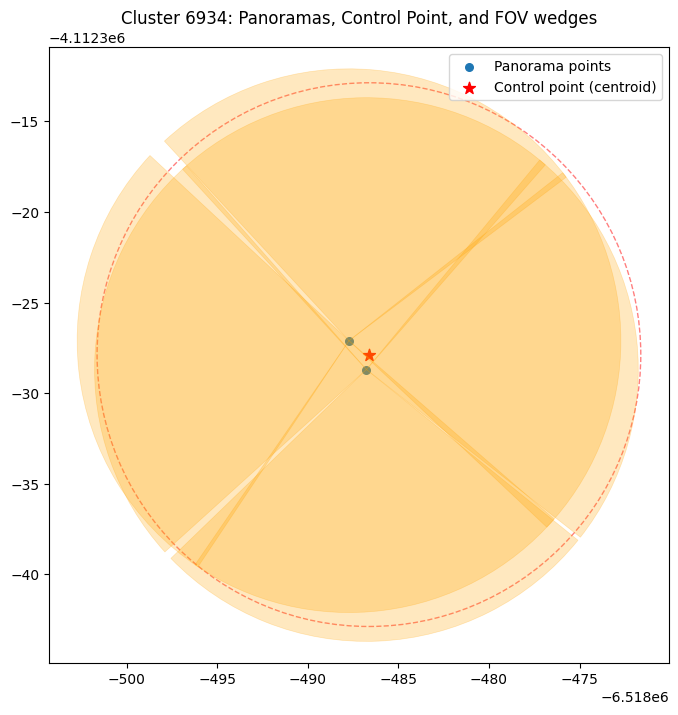

In [30]:
# 6) Matplotlib: plot points, control point, and FOV wedges from heading_fov.csv


fig, ax = plt.subplots(figsize=(8, 8))

# Scatter panoramas
xs = [p.x for p in panos_xy]
ys = [p.y for p in panos_xy]
ax.scatter(xs, ys, c='tab:blue', s=30, label='Panorama points')

# Control point
ax.scatter([cp_xy.x], [cp_xy.y], c='red', s=80, marker='*', label='Control point (centroid)')

# Optional: small circle around control point (e.g., 10 m radius)
cp_circle = Circle((cp_xy.x, cp_xy.y), radius=15.0, edgecolor='red', facecolor='none', linestyle='--', alpha=0.5)
ax.add_patch(cp_circle)

# Draw wedges for each view record
def draw_wedge(ax, center_point, heading_deg, fov_deg, radius=25.0, color='orange', alpha=0.25):
    # Matplotlib Wedge uses degrees counter-clockwise from +x axis.
    start = (heading_deg - fov_deg/2.0)
    end = (heading_deg + fov_deg/2.0)
    wedge = Wedge((center_point.x, center_point.y), r=radius, theta1=start, theta2=end, color=color, alpha=alpha, linewidth=0.5)
    ax.add_patch(wedge)

for _, row in hfov_c.iterrows():
    pid = row['pano_id']
    heading = float(row['heading'])
    fov = float(row['fov'])
    pxy = pano_xy_map.get(pid)
    if pxy is None:
        continue
    draw_wedge(ax, pxy, heading, fov, radius=15.0, color='orange', alpha=0.25)

ax.set_aspect('equal', adjustable='datalim')
ax.set_title(f'Cluster {CLUSTER_ID}: Panoramas, Control Point, and FOV wedges')
ax.legend(loc='best')
plt.show()

Images directory: ../data/tresdefebrero/image_testing/6934
Found 16 images


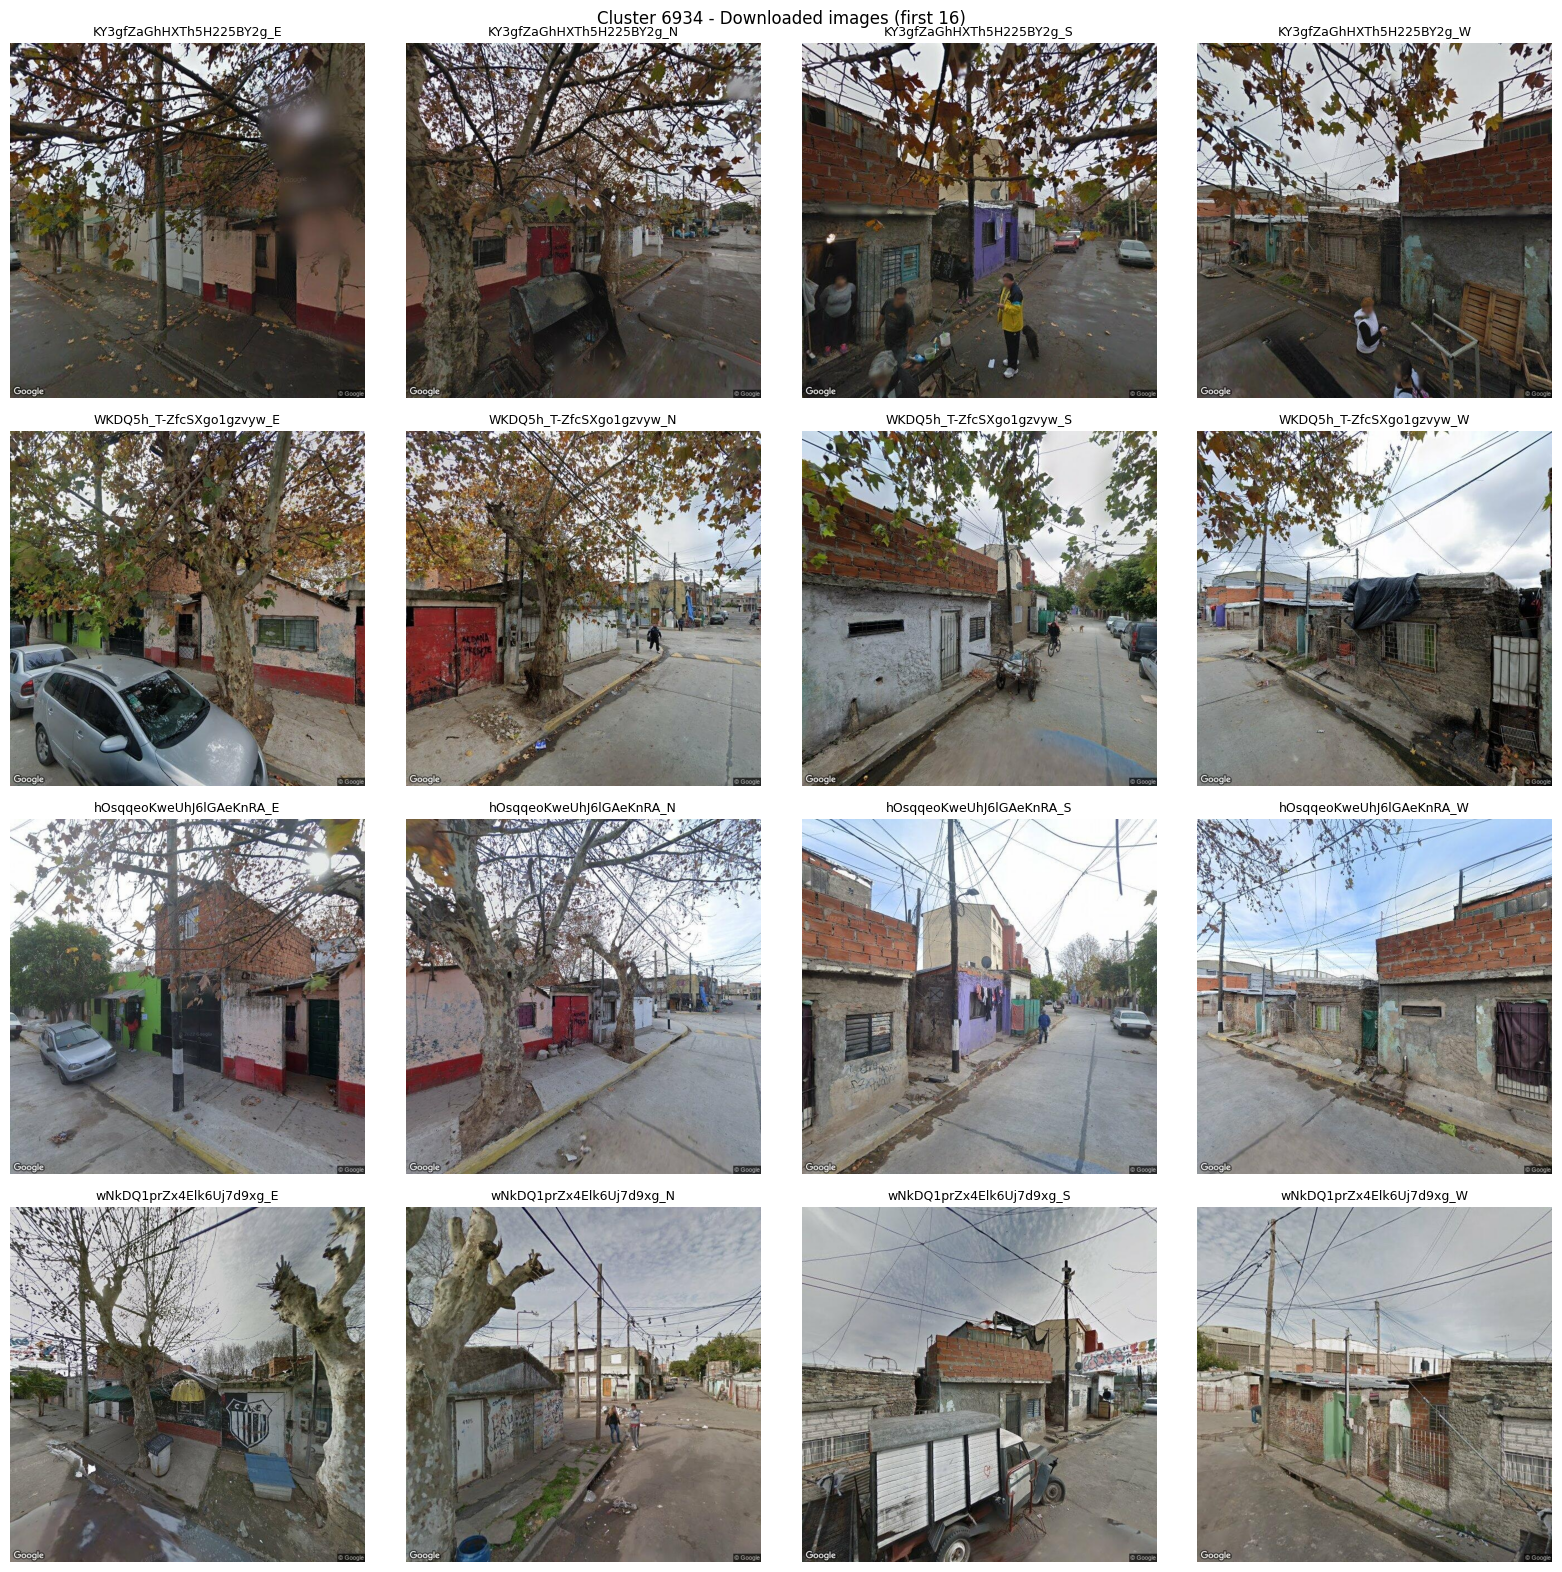

In [31]:
# 7) Compare with downloaded images for this cluster
print('Images directory:', IMAGES_BASE_DIR)
if not IMAGES_BASE_DIR.exists():
    print('No images directory found. Run notebooks/streetview_image_downloader.ipynb first for this cluster.')
else:
    image_files = sorted([p for p in IMAGES_BASE_DIR.glob('*.jpg')])
    print(f'Found {len(image_files)} images')
    
    # Show a grid of up to 8 images
    n = min(16, len(image_files))
    cols = 4
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten() if n > 1 else [axes]
    for i in range(cols*rows):
        ax = axes[i]
        if i < n:
            img_path = image_files[i]
            try:
                img = Image.open(img_path)
                ax.imshow(img)
                view_id = img_path.stem
                ax.set_title(view_id, fontsize=9)
                ax.axis('off')
            except Exception as e:
                ax.text(0.5, 0.5, f'Error: {e}', ha='center')
                ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle(f'Cluster {CLUSTER_ID} - Downloaded images (first {n})')
    plt.tight_layout()
    plt.show()

In [22]:
# 8) Optional: Per-pano diagnostic comparing wedge to image filename set
# Match images back to hfov rows using view_id = pano_id + '_' + direction (per pipeline)
if IMAGES_BASE_DIR.exists():
    available_views = {p.stem for p in IMAGES_BASE_DIR.glob('*.jpg')}
    hfov_c = hfov_c.copy()
    hfov_c['view_id'] = hfov_c['pano_id'].astype(str) + '_' + hfov_c['direction'].astype(str)
    hfov_c['has_image'] = hfov_c['view_id'].isin(available_views)
    print(hfov_c[['pano_id','direction','heading','fov','has_image']].head(12))
else:
    print('Images directory not found; skipping per-view matching')

                      pano_id direction  heading    fov  has_image
85309  KY3gfZaGhHXTh5H225BY2g         N    84.87   95.8       True
85310  KY3gfZaGhHXTh5H225BY2g         E   357.43   81.5       True
85311  KY3gfZaGhHXTh5H225BY2g         S   277.25   83.5       True
85312  KY3gfZaGhHXTh5H225BY2g         W   186.66   99.2       True
85313  WKDQ5h_T-ZfcSXgo1gzvyw         N    90.70   83.7       True
85314  WKDQ5h_T-ZfcSXgo1gzvyw         E     6.16   88.5       True
85315  WKDQ5h_T-ZfcSXgo1gzvyw         S   272.55   97.1       True
85316  WKDQ5h_T-ZfcSXgo1gzvyw         W   176.80   90.7       True
85317  hOsqqeoKweUhJ6lGAeKnRA         N    81.61   99.8       True
85318  hOsqqeoKweUhJ6lGAeKnRA         E   354.96   77.9       True
85319  hOsqqeoKweUhJ6lGAeKnRA         S   279.19   79.3       True
85320  hOsqqeoKweUhJ6lGAeKnRA         W   190.47  102.9       True
